In [54]:
import os
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# OGS-PHREEQC-Benchmark: CO2 injection into Opalinus Clay

## Overview
The present numerical work is motivated by the CO2LPIE project (shortened as CL-experiment) [1], which is an in-situ experiment that is being conducted at the Mont Terri
rock laboratory.
In the experiment, carbon dioxide (CO2) is injected into the Opalinus Clay leading to changes in its hydraulic, mechanical and chemical properties.
In general, these processes are of great interest in the evaluation of barrier intergrity.

Two scenarios are considered in this benchmark.
In the first scenario, the pure CO2 gas induced Calcite dissolution is simulated by OGS6-IPhreeqc and the results are verified with the related PHREEQC example presented by Appelo and Postma [2].
A comprehensive information regarding the computational procedure of OGS6-IPhreeqc can be found by the work from Lu et al. [3].
In the second scenario, the simulation considers a more accurate representation of chemical environments based on the CL Project.
This includes the incorporation of primary minerals typically found in Opalinus Clay and the relevant composition of species present in the porewater.


## Scenario #1: Kinetics of CO2 induced calcite dissolution

### Problem description

In this case, carbon dioxide ($CO_2$) gas with a partial pressure $10^{-1.5}$ bar is injected into a fluid containing Calcite.
The temperature is maintained at 10 °C, the fluid’s pH value is set at 6 and the initial concentration of Calcite is 1 mol/kgw.
The dissolution of the CO2 gas in water together with the Calcite dissolution pathways can be described with the following reactions (Plummer et al. [4], Appelo and Postma [2]).

$$\require{mhchem}$$
$$ \ce{CO2_{(g)} + H2O -> H2CO3^{\ast}} $$
$$ \ce{CaCO3 + H+ <=> Ca^2+ + HCO3-} $$
$$ \ce{CaCO3 + H2CO3^{\ast} <=> Ca^2+ + 2HCO3-} $$
$$ \ce{CaCO3 + H2O <=> Ca^2+ + HCO3- + OH-} $$

Two kinetic rates are adopted to describe the Calcite dissolution.
The first approach involves a simplified rate calculation derived directly from the current concentration of calcium,
employing the following formula: $rate = 10^{-6.91} - 10^{-1.52} * (c_{Ca})^2$.
And another one is the well known PWP rate which proposed by Plummer et al. [4].
The formulae of the PWP approach is available to be found in the PHREEQC database e.g. phreeqc.dat.
In the numerical experiment, the total simulation time is 30 000 s.
Details about the case study is described in the example 5.9 from Appelo and Postma [2].
The related PHREEQC script is available online to be found [5].

### Model and results

A simple 1D line-element model with one element is constructed in this work.
The coupled Hydraulic-Chemical (HC) Process is adopted for the OGS6-IPhreeqc simulation.
To match the PHREEQC example, the advection and diffusion have been set to zero in the modelling.
The initial conditions and chemical parameters are provided as outlined in the associated example.
The Fig. 1 depicts the comparison between the computed results obtained from the OGS6-IPhreeqc model and the results derived from PHREEQC, which shows a very
good agreement with each other.
The processing and postprocessing of the simulation are showed in the following notebook.

### 1) Solve the numerical model

In [55]:
out_dir = os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# simple
prj_name = "calcite_simple.prj"

! ogs {prj_name} -o {out_dir} > {out_dir}/out_simple.txt

# pwp
prj_name = "calcite_pwp.prj"

t0 = time.time()
print(">>> OGS started execution ... <<<")

! ogs {prj_name} -o {out_dir} > {out_dir}/out_pwp.txt

tf = time.time()
print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

/bin/bash: ogs: command not found
>>> OGS started execution ... <<<
/bin/bash: ogs: command not found
>>> OGS terminated execution  <<< Elapsed time:  0.13  s.


### 2) Plot the results

Results can be conveniently visualized with <a href="https://github.com/joergbuchwald/VTUinterface">VTUinterface</a>. The results computed by OGS-6 are compared with the results computed by PHREEQC (files `PHREEQC_results_simple.txt` and `PHREEQC_results_pwp.txt`).

slight changes of interpolated values if defaults are/were used.
slight changes of interpolated values if defaults are/were used.


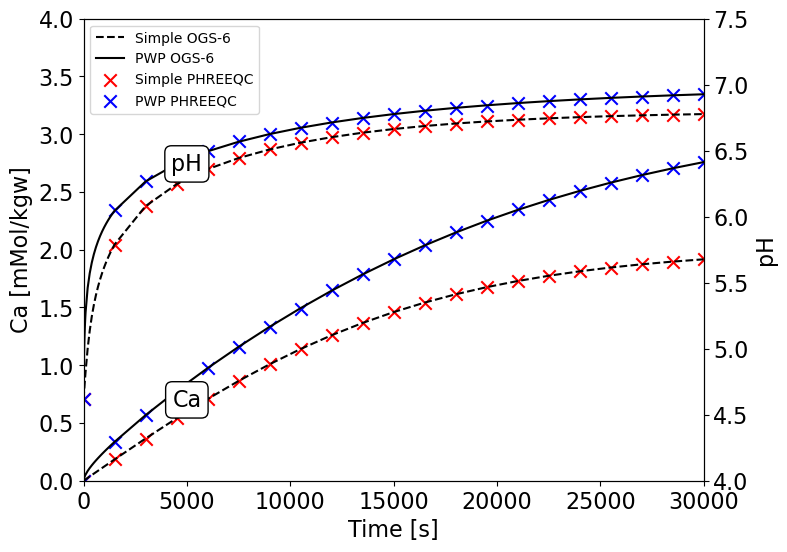

In [58]:
### Read OGS-6 simulation results

# simple
# pvdfile_simple = vtuIO.PVDIO("./sce1_results_simple/calcite_simple.pvd", dim=1)
pvdfile_simple = vtuIO.PVDIO(f"{out_dir}/calcite_simple.pvd", dim=1)

# pwp
# pvdfile_pwp = vtuIO.PVDIO("./sce1_results_pwp/calcite_pwp.pvd", dim=1)
pvdfile_pwp = vtuIO.PVDIO(f"{out_dir}/calcite_pwp.pvd", dim=1)

# Read PHREEQC results

# simple
phreeqc_result_df_simple = pd.read_csv(
    "./PHREEQC_results_simple.txt", sep="\s+", header=0, skipinitialspace=True
)

# pwp
phreeqc_result_df_pwp = pd.read_csv(
    "./PHREEQC_results_PWP.txt", sep="\s+", header=0, skipinitialspace=True
)

### visulalization
# results at point [0, 0, 0] are selected for display
point = {"pt0": (0.0, 0.0, 0.0)}

# plot
fig1 = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

plt.rcParams["axes.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.title_fontsize"] = 16

## results of 'Ca'
# OGS-6
ax.plot(
    pvdfile_simple.timesteps,
    pvdfile_simple.read_time_series("Ca", point)["pt0"] * 1e3,
    c="k",
    linestyle="--",
    label="Simple " + "OGS-6",
)
ax.plot(
    pvdfile_pwp.timesteps,
    pvdfile_pwp.read_time_series("Ca", point)["pt0"] * 1e3,
    c="k",
    label="PWP " + f"OGS-6",
)
# PHREEQC
ax.scatter(
    phreeqc_result_df_simple.loc[:, "x"] * 1e3,
    phreeqc_result_df_simple.loc[:, "Ca"],
    c="r",
    s=80,
    marker="x",
    label="Simple " + f"PHREEQC",
)
ax.scatter(
    phreeqc_result_df_pwp.loc[:, "x"] * 1e3,
    phreeqc_result_df_pwp.loc[:, "Ca"],
    c="b",
    s=80,
    marker="x",
    label="PWP " + f"PHREEQC",
)
ax.set_xlim([0, 3e4])
ax.set_ylim([0, 4])
ax.set_ylabel("Ca [mMol/kgw]")
ax.set_xlabel("Time [s]")
ann = ax.annotate(
    "Ca",
    xy=(5000, 0.7),
    xycoords="data",
    va="center",
    ha="center",
    bbox=dict(boxstyle="round", fc="w"),
    fontsize=16,
)
ax.legend(loc="upper left", fontsize=10)

## results of 'pH'
ax2 = ax.twinx()
# OGS-6
ax2.plot(
    pvdfile_simple.timesteps,
    -np.log10(pvdfile_simple.read_time_series("H", point)["pt0"]),
    c="k",
    linestyle="--",
    label="Simple " + "OGS-6",
)
ax2.plot(
    pvdfile_pwp.timesteps,
    -np.log10(pvdfile_pwp.read_time_series("H", point)["pt0"]),
    c="k",
    label="PWP " + f"OGS-6",
)
# PHREEQC
ax2.scatter(
    phreeqc_result_df_simple.loc[:, "x"] * 1e3,
    phreeqc_result_df_simple.loc[:, "pH"],
    c="r",
    s=80,
    marker="x",
    label="simple " + f"PHREEQC",
)
ax2.scatter(
    phreeqc_result_df_pwp.loc[:, "x"] * 1e3,
    phreeqc_result_df_pwp.loc[:, "pH"],
    c="b",
    s=80,
    marker="x",
    label="PWP " + f"PHREEQC",
)
ax2.set_xlim([0, 3e4])
ax2.set_ylim([4, 7.5])
ax2.set_ylabel("pH")
ax2.set_xlabel("Time [s]")
ann1 = ax2.annotate(
    "pH",
    xy=(5000, 6.4),
    xycoords="data",
    va="center",
    ha="center",
    bbox=dict(boxstyle="round", fc="w"),
    fontsize=16,
)

Fig. 1: pH and calcium increase with kinetic dissolution of Calcite.

## Scenario #2: Modelling of the CO2 injection into Opalinus Clay

### model description

The identical 1D line-element model utilized in scenario #1 is employed for the OGS6-IPhreeqc simulation.
In this case, chemical environments based on the CL-experiment are considered.
For the porous medium in the OGS-6 model, in terms of the solid component, the following mineral composition is assumed in this work: 36% illite, 24% kaolinite, 7.5% calcite and 2.5% dolomite-dis (namely sedimentary (disordered) dolomite).
A more detailed description of the mineral composition of Opalinus Clay can be found in the work of Thury [6].
During the simulation, a constant carbon dioxide ($CO_2$) gas with a partial pressure of $10^{1.5}$ bar is applied to the model domain as the equilibrium phase.
Consequently, the dissolved CO2 results in an alteration in the acidity of the porewater and leads to the different chemical reactions of each mineral.
The related reaction formulae are described in the PHREEQC database `llnl.dat`.
The adopted kinetic dissolution rate of each mineral are referenced from the transition state theory-based reaction mechanism following the work by Palandri and Kharaka [7]. The general equation formula reads

$${{Rate_\mathrm{mineral}}} = [ k_{\mathrm{acid_{mineral}}}^\mathrm{298.15K}{a_\mathrm{H^{+}}} + k_{\mathrm{neutral_{mineral}}}^\mathrm{298.15K} + k_{\mathrm{base_{mineral}}}^\mathrm{298.15K}{a_\mathrm{{H_{2}CO_{3}}^{*}}} ](1 - \mathrm{SR_{mineral}}),
\label{eq:transition_state}$$ with
$$\mathrm{SR_{mineral}} = \frac{\mathrm{IAP_{mineral}}}{K_\mathrm{eq,mineral}}.$$

where $a$ denotes the activity of the ion, and $\mathrm{SR}$ is the abbreviation for the saturation ratio of a phase, which describes the ion activity product $\mathrm{IAP}$ divided by equilibrium constant $K_\mathrm{eq}$.
In the simulation, the main species composition within the Opalinus Clay porewater are considered and the corresponding values are listed in table 1, following the
work of Wersin et al. [8].
In the model, the initial porosity is set to 0.15. Similarly to the scenario #1, hydraulic advection and diffusion are not considered in the simulation.

| Species | Value in [mol/kgw]      |
|---------|-------------------------|
| C(4)    | $3.89 \times 10^{-3}$   |
| Ca      | $1.89 \times 10^{-2}$   |
| Mg      | $2.197 \times 10^{-2}$  |
| Cl      | $3.2667 \times 10^{-1}$ |
| K       | $1.92 \times 10^{-3}$   |
| Na      | $2.8067 \times 10^{-1}$ |
| S(6)    | $1.679 \times 10^{-2}$  |
| Al      | $2.295 \times 10^{-10}$ |
| Si      | $1.7 \times 10^{-5}$    |
| Sr      | $4.6 \times 10^{-5}$    |

Table 1: concentration of the species in the Opalinus Clay porewater

For verification purposes, a corresponding PHREEQC model was constructed with identical parameter settings.

### Results

The left figure in Fig. 2 illustrates the evolution of calcium and magnesium molality during the CO2 injection computed from the OGS-6 and PHREEQC model.
The results of the two software programs match perfectly.
And the right figure in Fig. 2 illustrates the evolution of the dissoluted molality of each minerals during the simulation.
Only calcite and dolomite have been partially dissolved due to CO2 injection.
In contrast, clay minerals of illite and kaolinite were hardly affected.
The kinetic dissolution rate of calcite and dolomite is mostly controlled by their saturation ratio states.
When the SR value reaches 1, the dissolution process stops.


![Figure 2](figures/results_cl_comparision_sce2.png)
Fig. 2: Left: evolution of the calcium and magnesium molality during the CO2 injection; Right: evolution of the dissoluted minearals molality and the related saturation ratio of calcite and dolomite over the time.

## Literature

[1] BGR, CO2LPIE project, 2023. URL: [https://www.bgr.bund.de/DE/Themen/Endlagerung/Projekte/Wirtsgesteine_geotechnische_Barrieren/laufend/Nur-Deutsch/mont_terri_experimente.html?nn=1542156](https://www.bgr.bund.de/DE/Themen/Endlagerung/Projekte/Wirtsgesteine_geotechnische_Barrieren/laufend/Nur-Deutsch/mont_terri_experimente.html?nn=1542156).

[2] C. A. J. Appelo, D. Postma, Geochemistry, groundwater and pollution, CRC press, 2004.

[3] R. Lu, T. Nagel, J. Poonoosamy, D. Naumov, T. Fischer, V. Montoya, O. Kolditz, H. Shao, A new operator-splitting finite element scheme for reactive transport modeling in saturated porous media, Computers and Geosciences 163 (2022) 105106. URL: https://doi.org/10.1016/j.cageo.2022.105106. doi:10.1016/j.cageo.2022.105106.

[4] L. N. Plummer, T. M. Wigley, D. L. Parkhurst, KINETICS OF CALCITE DISSOLUTION IN CO2-WATER SYSTEMS AT 5 degree TO 60 degree C AND 0. 0 TO 1. 0 ATM CO2., 1978.

[5] C. A. J. Appelo, D. Postma, Example 5.9: Kinetic dissolution of calcite, 2023. URL: https://www.hydrochemistry.eu/a&p/5/ex_5_9.phr.

[6] M. Thury, The characteristics of the Opalinus Clay investigated in the Mont Terri underground rock laboratory in Switzerland, 2002. doi:10.1016/S1631-0705(02)01372-5.

[7] J. L. Palandri, Y. K. Kharaka, A compilation of rate parameters of water-mineral interaction kinetics for application to geochemical modeling (2004).

[8] P. Wersin, M. Mazurek, T. Gimmi, Porewater chemistry of Opalinus Clay revisited: Findings from 25 years of data collection at the Mont Terri Rock Laboratory, Applied Geochemistry 138 (2022) 105234. URL: https://doi.org/10.1016/j.apgeochem.2022.105234. doi:10.1016/j.apgeochem.2022.105234.


**Credits:**

Shuang Chen, Vinay Kumar, Jobst Maßmann